In [1]:
import datasets
from torchvision.transforms import ColorJitter, transforms
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import pandas as pd
import numpy as np

Data from: [kaggle](https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation/versions/2?resource=download)

Example code from: [huggingface](https://huggingface.co/blog/fine-tune-segformer)

In [2]:
meta_data = pd.read_csv('forest_seg_img/forest_segmented/meta_data.csv')

In [3]:
meta_data

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg
...,...,...
5103,998002_sat_31.jpg,998002_mask_31.jpg
5104,998002_sat_32.jpg,998002_mask_32.jpg
5105,998002_sat_40.jpg,998002_mask_40.jpg
5106,998002_sat_41.jpg,998002_mask_41.jpg


In [4]:
IMAGES = [f"forest_seg_img/forest_segmented/images/{image_name}" for image_name in meta_data['image'][:51]]
MASKS = [f"forest_seg_img/forest_segmented/masks/{image_name}" for image_name in meta_data['mask'][:51]]
dataset = datasets.Dataset.from_dict({"pixel_values": IMAGES, "label": MASKS}, features=datasets.Features({"pixel_values": datasets.Image(), "label": datasets.Image()}))

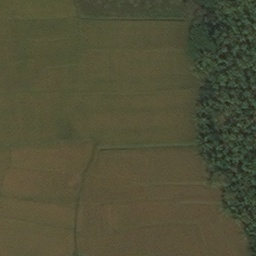

In [5]:
dataset["pixel_values"][0]

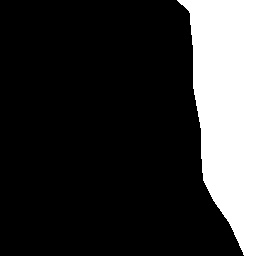

In [6]:
dataset["label"][0]

In [7]:
dataset

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 51
})

In [8]:
dataset[0]

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'label': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>}

In [9]:
dataset = dataset.train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]


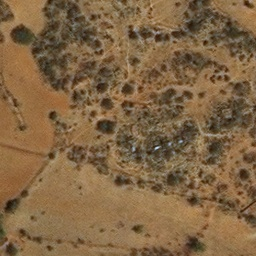

In [10]:
train_ds["pixel_values"][0]

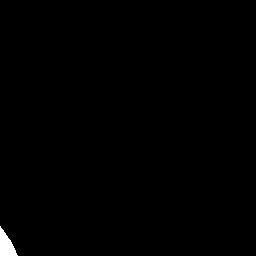

In [11]:
train_ds["label"][0]

In [12]:
id2label = {
    0: "unlabeled",
    1: "trees"
}

label2id = {
    "unlabeled": 0,
    "trees": 1
}

num_labels = len(id2label)

In [13]:
transform = transforms.Compose([
    transforms.PILToTensor()
])

In [14]:


feature_extractor = SegformerFeatureExtractor(return_tensors="pt")
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 

def train_transforms(example_batch):
    images = [transform(jitter(x)) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    new_labels = []
    for x in inputs['labels']:
        grayscale_arr = np.max(x, axis=2)
        grayscale_arr[grayscale_arr > 0] = 1
        new_labels.append(grayscale_arr)
    inputs['labels'] = new_labels
    return inputs


def val_transforms(example_batch):
    images = [transform(x)  for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    new_labels = []
    for x in inputs['labels']:
        grayscale_arr = np.max(x, axis=2)
        grayscale_arr[grayscale_arr > 0] = 1
        new_labels.append(grayscale_arr)
    inputs['labels'] = new_labels
    
    return inputs



/Users/eikerogall/Documents/neuefische/ds-fine-tuning-with-hf/.venv/lib/python3.11/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [17]:

# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [18]:


pretrained_model_name = "nvidia/mit-b0" 
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.classifier.bias', 'decode_head.batch_norm.r

In [19]:
from transformers import TrainingArguments

epochs = 50
lr = 0.00006
batch_size = 2


training_args = TrainingArguments(
    "model/segformer",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    hub_strategy="end",
)

In [20]:
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.do_reduce_labels,
        )
    
    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})
    
    return metrics

In [21]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [22]:
trainer.train()

/Users/eikerogall/Documents/neuefische/ds-fine-tuning-with-hf/.venv/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 0.6685, 'learning_rate': 5.994e-05, 'epoch': 0.05}
{'loss': 0.6843, 'learning_rate': 5.988e-05, 'epoch': 0.1}
{'loss': 0.6464, 'learning_rate': 5.982e-05, 'epoch': 0.15}
{'loss': 0.6857, 'learning_rate': 5.9760000000000004e-05, 'epoch': 0.2}
{'loss': 0.7183, 'learning_rate': 5.97e-05, 'epoch': 0.25}
{'loss': 0.6438, 'learning_rate': 5.964e-05, 'epoch': 0.3}
{'loss': 0.6239, 'learning_rate': 5.958e-05, 'epoch': 0.35}
{'loss': 0.6807, 'learning_rate': 5.952e-05, 'epoch': 0.4}
{'loss': 0.56, 'learning_rate': 5.946e-05, 'epoch': 0.45}
{'loss': 0.565, 'learning_rate': 5.94e-05, 'epoch': 0.5}
{'loss': 0.6204, 'learning_rate': 5.934e-05, 'epoch': 0.55}
{'loss': 0.5554, 'learning_rate': 5.928e-05, 'epoch': 0.6}
{'loss': 0.68, 'learning_rate': 5.922e-05, 'epoch': 0.65}
{'loss': 0.4947, 'learning_rate': 5.916e-05, 'epoch': 0.7}
{'loss': 0.6128, 'learning_rate': 5.91e-05, 'epoch': 0.75}
{'loss': 0.6259, 'learning_rate': 5.9040000000000004e-05, 'epoch': 0.8}
{'loss': 0.7232, 'learning_rat

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.5933942198753357, 'eval_mean_iou': 0.40127195515634984, 'eval_mean_accuracy': 0.8025439103126997, 'eval_overall_accuracy': 0.8025439103126997, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8025439103126997, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8025439103126997, 'eval_runtime': 5.1941, 'eval_samples_per_second': 2.118, 'eval_steps_per_second': 1.155, 'epoch': 1.0}
{'loss': 0.5823, 'learning_rate': 5.8740000000000003e-05, 'epoch': 1.05}
{'loss': 0.7009, 'learning_rate': 5.868e-05, 'epoch': 1.1}
{'loss': 0.6437, 'learning_rate': 5.862e-05, 'epoch': 1.15}
{'loss': 0.5588, 'learning_rate': 5.856e-05, 'epoch': 1.2}
{'loss': 0.5988, 'learning_rate': 5.85e-05, 'epoch': 1.25}
{'loss': 0.5193, 'learning_rate': 5.844e-05, 'epoch': 1.3}
{'loss': 0.3858, 'learning_rate': 5.838e-05, 'epoch': 1.35}
{'loss': 0.4362, 'learning_rate': 5.832e-05, 'epoch': 1.4}
{'loss': 0.5619, 'learning_rate': 5.826e-05, 'epoch': 1.45}
{'loss': 0.4865, 'learning_rate': 5.82e-05, 'epoc

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.43814173340797424, 'eval_mean_iou': 0.4631363396877529, 'eval_mean_accuracy': 0.9262726793755058, 'eval_overall_accuracy': 0.9262726793755058, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9262726793755058, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9262726793755058, 'eval_runtime': 5.1381, 'eval_samples_per_second': 2.141, 'eval_steps_per_second': 1.168, 'epoch': 2.0}
{'loss': 0.4817, 'learning_rate': 5.754e-05, 'epoch': 2.05}
{'loss': 0.6803, 'learning_rate': 5.748e-05, 'epoch': 2.1}
{'loss': 0.6929, 'learning_rate': 5.742e-05, 'epoch': 2.15}
{'loss': 0.5429, 'learning_rate': 5.736e-05, 'epoch': 2.2}
{'loss': 0.6155, 'learning_rate': 5.73e-05, 'epoch': 2.25}
{'loss': 0.5089, 'learning_rate': 5.724e-05, 'epoch': 2.3}
{'loss': 0.3399, 'learning_rate': 5.718e-05, 'epoch': 2.35}
{'loss': 0.6956, 'learning_rate': 5.712e-05, 'epoch': 2.4}
{'loss': 0.2183, 'learning_rate': 5.706e-05, 'epoch': 2.45}
{'loss': 0.3668, 'learning_rate': 5.6999999999999996e-05, 'epo

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.35443174839019775, 'eval_mean_iou': 0.44143850745674146, 'eval_mean_accuracy': 0.8828770149134829, 'eval_overall_accuracy': 0.8828770149134829, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8828770149134829, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8828770149134829, 'eval_runtime': 5.1347, 'eval_samples_per_second': 2.142, 'eval_steps_per_second': 1.169, 'epoch': 3.0}
{'loss': 0.5429, 'learning_rate': 5.634e-05, 'epoch': 3.05}
{'loss': 0.2202, 'learning_rate': 5.6279999999999996e-05, 'epoch': 3.1}
{'loss': 0.2264, 'learning_rate': 5.622000000000001e-05, 'epoch': 3.15}
{'loss': 0.5441, 'learning_rate': 5.6160000000000004e-05, 'epoch': 3.2}
{'loss': 0.3473, 'learning_rate': 5.61e-05, 'epoch': 3.25}
{'loss': 0.5105, 'learning_rate': 5.6040000000000006e-05, 'epoch': 3.3}
{'loss': 0.3083, 'learning_rate': 5.598e-05, 'epoch': 3.35}
{'loss': 0.3516, 'learning_rate': 5.592000000000001e-05, 'epoch': 3.4}
{'loss': 0.2921, 'learning_rate': 5.5860000000000004e-05, 

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.5324253439903259, 'eval_mean_iou': 0.33452723878772955, 'eval_mean_accuracy': 0.6690544775754591, 'eval_overall_accuracy': 0.6690544775754591, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.6690544775754591, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.6690544775754591, 'eval_runtime': 5.1292, 'eval_samples_per_second': 2.145, 'eval_steps_per_second': 1.17, 'epoch': 4.0}
{'loss': 0.5602, 'learning_rate': 5.5140000000000004e-05, 'epoch': 4.05}
{'loss': 0.7892, 'learning_rate': 5.508e-05, 'epoch': 4.1}
{'loss': 0.4321, 'learning_rate': 5.5020000000000005e-05, 'epoch': 4.15}
{'loss': 0.187, 'learning_rate': 5.496e-05, 'epoch': 4.2}
{'loss': 0.1945, 'learning_rate': 5.4900000000000006e-05, 'epoch': 4.25}
{'loss': 0.7021, 'learning_rate': 5.4840000000000003e-05, 'epoch': 4.3}
{'loss': 0.4019, 'learning_rate': 5.478e-05, 'epoch': 4.35}
{'loss': 0.7104, 'learning_rate': 5.4720000000000005e-05, 'epoch': 4.4}
{'loss': 0.4475, 'learning_rate': 5.466e-05, 'epoch': 4.45

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.36792847514152527, 'eval_mean_iou': 0.43604488529273844, 'eval_mean_accuracy': 0.8720897705854769, 'eval_overall_accuracy': 0.8720897705854769, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8720897705854769, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8720897705854769, 'eval_runtime': 5.3419, 'eval_samples_per_second': 2.059, 'eval_steps_per_second': 1.123, 'epoch': 5.0}
{'loss': 0.5818, 'learning_rate': 5.394e-05, 'epoch': 5.05}
{'loss': 0.1698, 'learning_rate': 5.3880000000000006e-05, 'epoch': 5.1}
{'loss': 0.5487, 'learning_rate': 5.382e-05, 'epoch': 5.15}
{'loss': 0.3385, 'learning_rate': 5.376e-05, 'epoch': 5.2}
{'loss': 0.9215, 'learning_rate': 5.3700000000000004e-05, 'epoch': 5.25}
{'loss': 0.4848, 'learning_rate': 5.364e-05, 'epoch': 5.3}
{'loss': 0.2884, 'learning_rate': 5.3580000000000005e-05, 'epoch': 5.35}
{'loss': 0.5411, 'learning_rate': 5.352e-05, 'epoch': 5.4}
{'loss': 0.2815, 'learning_rate': 5.346e-05, 'epoch': 5.45}
{'loss': 0.4137, 'lea